<a href="https://colab.research.google.com/github/Snowyyxx/Pytorch/blob/main/CNN_Clothing_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Basic:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Torch Vision:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # Converts images or numpy arrays to tensors!

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Getting dataset:

In [4]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)


In [5]:
len(train_data),len(test_data)

(60000, 10000)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
### Visualizing the data!

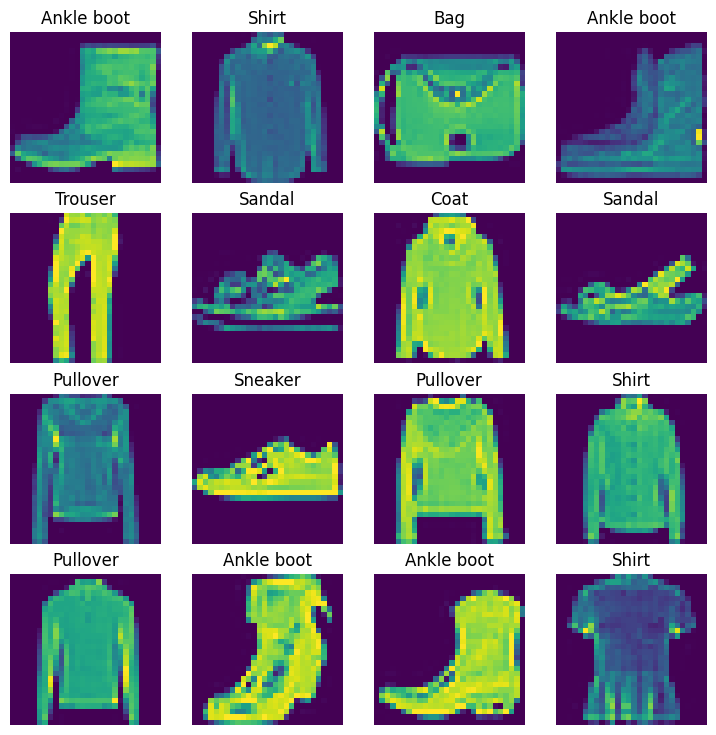

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, col =4,4

for i in range(1,rows*col+1):
  random_index = torch.randint(0,len(train_data),size=[])
  img, label = train_data[random_index]
  fig.add_subplot(rows,col,i)
  plt.imshow(img.squeeze())
  plt.title(class_names[label])
  plt.axis(False)

### Prepare Dataloader:
This is in form of data set. Dataloader turns our dataset into python iterable. More specificaly, we need to turn into batches of data!
Because it is more computationally efficient. Batch size =32

In [10]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=32,shuffle=False)

In [11]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [12]:
train_feature_batch,train_label_batch=next(iter(train_dataloader))
test_feature_batch,test_label_batch = next(iter(test_dataloader))

In [13]:
train_feature_batch.shape  #batch_size,color_code,length,breadth!

torch.Size([32, 1, 28, 28])

In [14]:
train_label_batch.shape

torch.Size([32])

Text(0.5, 1.0, 'Trouser')

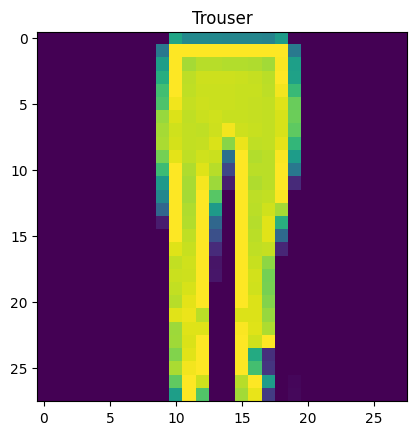

In [15]:
# show a sample:
random_index = torch.randint(0,len(train_feature_batch),size=[])
image,label = train_feature_batch[random_index],train_label_batch[random_index]
plt.imshow(train_feature_batch[random_index].squeeze())
plt.title(class_names[label])

### Building a baseline model!

In [16]:
#Create a flatten layer:
flatten_model = nn.Flatten();

#get a sample:
x = train_feature_batch[0]


#flatten sample:
output = flatten_model(x)
print(f"Before flatten: {x.shape}, and after flatten:{output.shape}") #colorchannel,height,weight -> colorchannel,height*weight

Before flatten: torch.Size([1, 28, 28]), and after flatten:torch.Size([1, 784])


In [17]:
class FashionModel(nn.Module):
  def __init__(self,input_shape: int,output_shape: int,hidden_units: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_shape)
    )

  def forward(self,x):
    x = self.layer_stack(x)
    return x

In [18]:
model = FashionModel(
    input_shape = 28*28, #output of flatten
    hidden_units=10, #nueoren in hidden layer
    output_shape=len(class_names) # one for every class
).to("cpu")
model

FashionModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [19]:
def accuracy_fn(y_pred,y_true):
    correct = torch.eq(y_pred,y_true).sum().item()
    acc = correct/len(test_dataloader)
    return acc

In [20]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

In [21]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = abs(start-end)
  print(f"Train time on {device}: total time taken is: {total_time:.3f} seconds")


In [22]:
from tqdm.auto import tqdm

C:\Users\adity\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# training loop:
from tqdm.auto import tqdm
train_time_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epochs: {epoch} \n----")
  train_loss=0
  for Batch,(X,y) in enumerate(train_dataloader):
    model.train()
    y_logits = model(X)
    loss = loss_fn(y_logits,y)
    train_loss = train_loss + loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss = train_loss / len(train_dataloader)

# testing loop:
test_loss,test_acc=0,0
model.eval()
with torch.inference_mode():
  for X,y in test_dataloader:
    test_prediction = model(X)
    test_loss =test_loss+ loss_fn(test_prediction,y)
    test_acc += accuracy_fn(y_true=y, y_pred=test_prediction.argmax(dim=1))
  test_loss = test_loss/len(test_dataloader)
  test_acc = test_acc/len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
train_time_end_cpu = timer()
total_train_time_model = print_train_time(start=train_time_cpu,end=train_time_end_cpu)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epochs: 0 
----


 33%|████████████████████████████                                                        | 1/3 [00:11<00:22, 11.04s/it]

Epochs: 1 
----


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:22<00:11, 11.21s/it]

Epochs: 2 
----


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:33<00:00, 11.18s/it]



Train loss: 0.45494 | Test loss: 0.46152, Test acc: 0.09%

Train time on None: total time taken is: 35.228 seconds


In [24]:
#Make predictions:
def eval_model(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,accuracy_fn):
  loss,acc =0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      y_pred = model(X)
      loss = loss + loss_fn(y_pred,y)
      acc =acc + accuracy_fn(y_pred=y_pred.argmax(dim=1),y_true=y)
    loss =loss/len(data_loader)
    acc = acc/len(data_loader)
  return {
      "model_loss":loss.item(),
      "model_acc": acc
  }
model_results = eval_model(model=model,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
model_results

{'model_loss': 0.4615230858325958, 'model_acc': 0.08550663985546442}

In [25]:
model_results['model_loss']

0.4615230858325958

In [26]:
class NonLinearModel(nn.Module):
  def __init__(self):
    super(NonLinearModel, self).__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 200),  # No need for `input_shape=` or `output_shape=`, just specify the dimensions
        nn.Sigmoid(),
        nn.Linear(200,100),
        nn.ReLU(),
        nn.Linear(100, len(class_names))  # Output raw scores for each class
    )

  def forward(self, x):
    return self.layer_stack(x)


In [27]:
model_1 = NonLinearModel()

In [28]:
# Train Model:
model_1 = model_1.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)
epochs = 3

# Function to calculate accuracy (assuming you didn't define it earlier)
def accuracy_fn(y_pred, y_true):
    return (y_pred == y_true).float().mean()

for epoch in range(epochs):
    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    print(f"Epoch: {epoch+1} \n----")
    
    # Training Loop
    model_1.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        
        train_pred = model_1(X)
        loss = loss_fn(train_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += accuracy_fn(train_pred.argmax(dim=1), y)
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    # Testing Loop
    model_1.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model_1(X)
            
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")


Epoch: 1 
----
Train loss: 1.79774 | Train accuracy: 0.44002
Test loss: 1.13064 | Test accuracy: 0.59335

Epoch: 2 
----
Train loss: 0.92614 | Train accuracy: 0.66998
Test loss: 0.79738 | Test accuracy: 0.70657

Epoch: 3 
----
Train loss: 0.71673 | Train accuracy: 0.74077
Test loss: 0.67662 | Test accuracy: 0.75040



# CNN : Convolution Neural Network!

In [29]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel,self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=100,kernel_size=(2,2),stride=1,padding=1), # inchannels = number of color channels
            nn.ReLU(),
            nn.Conv2d(in_channels=100,out_channels=100,kernel_size=(2,2),stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=100,out_channels=100,kernel_size=(2,2),stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=100,out_channels=100,kernel_size=(2,2),stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=100,out_channels=200,kernel_size=(3,3),stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(), #converts into single feature vector
            nn.Linear(in_features=1800, out_features=10)  # Here, change from 64 to 6400
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x= self.conv_block_3(x)
        x = self.classifier(x)
        return x
    #TinyVGG!

In [30]:
model_2 = CnnModel().to(device)
print(device)
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.01)
loss_fn = nn.CrossEntropyLoss()

cuda


In [31]:
# Training loop:
epochs =10
model_2.train()

for epoch in tqdm(range(epochs)):
    train_loss,train_acc= 0,0
    for batch, data in enumerate(train_dataloader):
        (X,y)=data
        X = X.to(device,dtype=torch.float32)
        y = y.to(device)
        train_pred = model_2(X)
        loss = loss_fn(train_pred,y)
        train_acc = accuracy_fn(train_pred.argmax(dim=1),y)
        train_loss = train_loss +loss
        train_acc =train_acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 2 == 0:    # print every 200 mini-batches
        print(f"[{epoch + 1}, {epoch + 1}] loss: {train_loss / len(train_dataloader):.3f}")
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

 10%|████████▎                                                                          | 1/10 [00:17<02:38, 17.62s/it]

[1, 1] loss: 1.323


 30%|████████████████████████▉                                                          | 3/10 [00:49<01:53, 16.26s/it]

[3, 3] loss: 0.434


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:18<01:17, 15.42s/it]

[5, 5] loss: 0.364


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:50<00:47, 15.76s/it]

[7, 7] loss: 0.323


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:21<00:15, 15.67s/it]

[9, 9] loss: 0.296


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.80s/it]


In [35]:
# Testing Loop for CNN:
confusion_marix=np.zeros((10,10))
model_2.eval()
acc=0
with torch.inference_mode():
    for data in test_dataloader:
        (test_features,test_labels) = data
        test_features = test_features.to(device)
        test_labels = test_labels.to(device)
        test_pred = model_2(test_features)
        loss = loss_fn(test_pred,test_labels)
        acc = acc+accuracy_fn(test_pred.argmax(dim=1),test_labels)
        test_loss = test_loss + loss    
        
    test_loss = test_loss/len(test_dataloader)
    acc = acc/len(test_dataloader)
    print(f"Test Loss: {test_loss}, Accuracy: {acc}")

Test Loss: 0.32071128487586975, Accuracy: 0.8796924948692322


In [57]:
import torch
import numpy as np

# Assuming you have N classes
N = 10  # Replace this with the actual number of classes
confusion_matrix = np.zeros((N, N))

model_2.eval()

with torch.no_grad():
    for data in test_dataloader:
        (test_features, test_labels) = data

        test_features = test_features.to(device, dtype=torch.float32)
        test_labels = test_labels.to(device)
    
        # Forward pass to get the predicted labels
        test_pred = model_2(test_features)
        pred_labels = test_pred.argmax(dim=1)
        
        # Fill in the confusion matrix
        for true, pred in zip(test_labels.cpu().numpy(), pred_labels.cpu().numpy()):
            confusion_matrix[true, pred] += 1

print(confusion_matrix)

normalised_confusion_matrix = confusion_matrix/len(test_dataloader)


[[691.   0.   9.  41.   2.   1. 239.   0.  17.   0.]
 [  0. 973.   0.  19.   5.   0.   1.   0.   2.   0.]
 [  8.   1. 732.   9. 137.   0. 107.   0.   6.   0.]
 [  7.   2.   4. 931.  12.   0.  40.   0.   4.   0.]
 [  1.   1.  37.  53. 808.   0.  96.   0.   4.   0.]
 [  0.   0.   0.   0.   0. 961.   0.  30.   3.   6.]
 [ 48.   1.  48.  35.  64.   0. 785.   0.  19.   0.]
 [  0.   0.   0.   0.   0.   6.   0. 982.   0.  12.]
 [  0.   1.   3.   4.   3.   1.   1.   4. 983.   0.]
 [  0.   0.   0.   0.   0.   4.   1.  46.   0. 949.]]


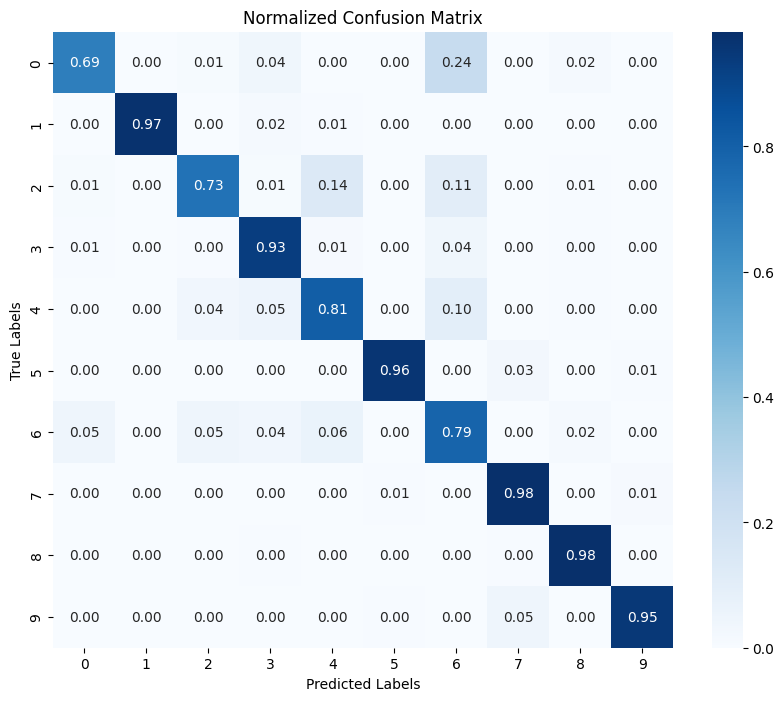

In [40]:
import seaborn as sns
# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_normalized, annot=True, fmt=".2f", cmap="Blues")  # Using '.2f' for floating point numbers
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()
